## COVID19 Forecasting Project

**ECE 685:** Deep Learning <br>
**Student:** Guillem Amat, Sebastian Soriano

<br>

#### Loading Packages

In [365]:
# Normal Packages
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import pdb
import csv
import os

In [366]:
# Torch Packages
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F

<br>

#### Loading Data

In [337]:
import warnings
warnings.filterwarnings("ignore") 

In [338]:
data = pd.read_csv(os.path.join(os.getcwd(), 'Final Project', 'Data', 'week_5', 'train.csv'))

<br>

**Creating Key for Location**

In [339]:
data.head()

,Id,County,Province_State,Country_Region,Population,Weight,Date,Target,TargetValue
0,1,NaN,NaN,Afghanistan,27657145,0.058359,1/23/2020,ConfirmedCases,0
1,2,NaN,NaN,Afghanistan,27657145,0.583587,1/23/2020,Fatalities,0
2,3,NaN,NaN,Afghanistan,27657145,0.058359,1/24/2020,ConfirmedCases,0
3,4,NaN,NaN,Afghanistan,27657145,0.583587,1/24/2020,Fatalities,0
4,5,NaN,NaN,Afghanistan,27657145,0.058359,1/25/2020,ConfirmedCases,0


In [340]:
data['County']         = data['County'].fillna('')
data['Province_State'] = data['Province_State'].fillna('')

In [341]:
location = data['Country_Region'] + data['Province_State'] + data['County']

In [342]:
locations = list(np.unique(location))

In [343]:
location_dictionary = {i: l for (i, l) in enumerate(locations)}

In [344]:
print(location_dictionary[1000])

USIndianaLaPorte


<br>

**Pivoting Data**

In [345]:
data = data.pivot(index=['Country_Region', 'Province_State', 'County', 'Date'], columns='Target', values='TargetValue')

In [346]:
data.head()

Target                                          ConfirmedCases  Fatalities
Country_Region Province_State County Date                                 
Afghanistan                          1/23/2020               0           0
                                     1/24/2020               0           0
                                     1/25/2020               0           0
                                     1/26/2020               0           0
                                     1/27/2020               0           0

<br>

**Scaling the Data**

In [302]:
...

Ellipsis

<br>

**Creating Torch Tensor**

In [347]:
result = data[['ConfirmedCases','Fatalities']].to_numpy()

In [348]:
dataset = result.reshape(-1, 140, 2)

In [349]:
train = dataset[:, :95, :]
test  = dataset[:, 95:, :]

In [350]:
train.shape, test.shape

((3463, 95, 2), (3463, 45, 2))

<br>

**Plotting the Data**

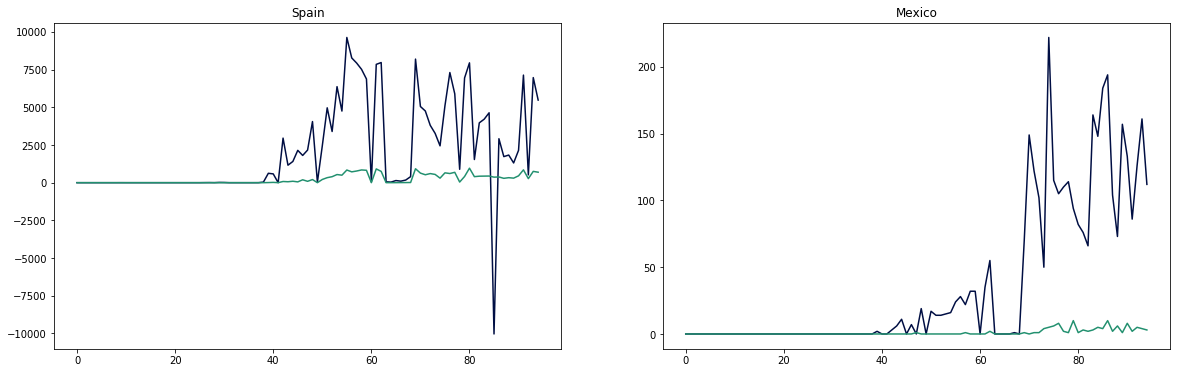

In [351]:
fig, axes = plt.subplots(ncols=2, figsize=(20, 6))

#Train 1
axes[0].set_title(location_dictionary[226])
axes[0].plot(train[226, :, 0], color='#000E43', label = 'Confirmed Cases')
axes[0].plot(train[226, :, 1], color='#22906F', label = 'Fatalities')

#Train 2
axes[1].set_title(location_dictionary[176])
axes[1].plot(train[177, :, 0], color='#000E43', label = 'Confirmed Cases')
axes[1].plot(train[177, :, 1], color='#22906F', label = 'Fatalities')

<br>

### Modeling

<br>

#### LSTM

**Sequence Creation**

In [352]:
train = np.sum(train, axis=0) 
test  = np.sum(test, axis=0)
#train = torch.sum(train, dim = 0)
#test  = torch.sum(test, dim = 0)

In [356]:
train.shape, test.shape

((95, 2), (45, 2))

In [357]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler = scaler.fit(train)
train = scaler.transform(train)
test = scaler.transform(test)

In [360]:
def create_sequences(data, seq_length):
    xs = []; ys = []
    for i in range(len(data) -seq_length -1):
        x = data[i:(i+seq_length)]
        y = data[i+seq_length]
        xs.append(x)
        ys.append(y)
    #pdb.set_trace()
    return np.array(xs), np.array(ys)

seq_length = 10
X_train, y_train = create_sequences(train, seq_length)
X_test, y_test   = create_sequences(test, seq_length)

In [361]:
X_train, y_train = torch.from_numpy(X_train).float(), torch.from_numpy(y_train).float()
X_test, y_test = torch.from_numpy(X_test).float(), torch.from_numpy(y_test).float()

<br>

**Neural Network**

In [370]:
class LSTMCoNet(nn.Module):
    def __init__(self, n_features, n_hidden, seq_len, n_layers):
        super().__init__()
        self.n_hidden = n_hidden
        self.seq_len  = seq_len
        self.n_layers = n_layers
        
        self.lstm = nn.LSTM(input_size=n_features,
                            hidden_size=n_hidden,
                            num_layers=n_layers,
                            dropout=0.5) 
        
        self.linear = nn.Linear(in_features=n_hidden, out_features=2)
     
    def reset_hidden_state(self):
        self.hidden = (torch.zeros(self.n_layers, self.seq_len, self.n_hidden),
                       torch.zeros(self.n_layers, self.seq_len, self.n_hidden))
            
    def forward(self, sequences):
        lstm_out, self.hidden = self.lstm(sequences.view(len(sequences), self.seq_len, -1),
                                          self.hidden)
            
        last_time_step = lstm_out.view(self.seq_len, len(sequences), self.n_hidden)[-1]
        y_pred = self.linear(last_time_step)
        return y_pred  

In [374]:
def train_model(model, train_data, train_labels, test_data=None, test_labels=None):
    
    loss_fn = torch.nn.MSELoss(reduction='sum')
    optimiser = torch.optim.Adam(model.parameters(), lr=0.00025)
    num_epochs = 150
    train_hist = np.zeros(num_epochs)
    test_hist = np.zeros(num_epochs)
    
    for t in range(num_epochs):
        model.reset_hidden_state()
        
        y_pred = model(X_train)
        loss = loss_fn(y_pred.float(), y_train)
        
        if test_data is not None:
            with torch.no_grad():
                y_test_pred = model(X_test)
                test_loss = loss_fn(y_test_pred.float(), y_test)
            test_hist[t] = test_loss.item()
            
            if t % 10 == 0:
                print(f'Epoch {t} train loss: {round(loss.item(), 2)} test loss: {round(test_loss.item(), 2)}')
        
        elif t % 10 == 0:
            print(f'Epoch {t} train loss: {round(loss.item(), 2)}')
            
        train_hist[t] = loss.item()
        optimiser.zero_grad()
        loss.backward()
        optimiser.step()
        
    return model.eval(), train_hist, test_hist

In [377]:
model = LSTMCoNet(n_features=2, n_hidden=512, seq_len=seq_length, n_layers=2)
model, train_hist, test_hist = train_model(model,X_train, y_train, X_test, y_test)

Epoch 0 train loss: 32.81 test loss: 33.98
Epoch 10 train loss: 20.12 test loss: 7.64
Epoch 20 train loss: 18.74 test loss: 15.65
Epoch 30 train loss: 18.08 test loss: 10.71
Epoch 40 train loss: 18.06 test loss: 13.2
Epoch 50 train loss: 18.0 test loss: 11.4
Epoch 60 train loss: 17.68 test loss: 11.89
Epoch 70 train loss: 16.88 test loss: 9.23
Epoch 80 train loss: 12.19 test loss: 91.66
Epoch 90 train loss: 11.88 test loss: 4.1
Epoch 100 train loss: 11.76 test loss: 2.49
Epoch 110 train loss: 11.72 test loss: 1.82
Epoch 120 train loss: 11.61 test loss: 2.84
Epoch 130 train loss: 11.45 test loss: 2.54
Epoch 140 train loss: 11.13 test loss: 1.96


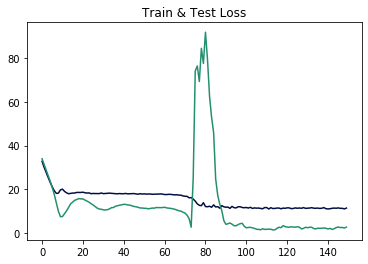

In [378]:
plt.title('Train & Test Loss')
plt.plot(train_hist, color='#000E43', label = 'Confirmed Cases')
plt.plot(test_hist, color='#22906F', label = 'Fatalities')

<br>

#### Appendix

**Feature Engineering Ideas:**

- Elderly Population Percentage
- GDP per Capita
- Population male percentage -> males are more likely to die
- Health indicators: Quality of health care sector, obesity...
- Number of Tests Administered
- Populatin Density